# Predict Online Gaming Behavior Dataset

# About Dataset

**Overview:**

This dataset captures comprehensive metrics and demographics related to player behavior in online gaming environments. It includes variables such as player demographics, game-specific details, engagement metrics, and a target variable reflecting player retention.

**Features:**

- **PlayerID:** Unique identifier for each player.
- **Age:** Age of the player.
- **Gender:** Gender of the player.
- **Location:** Geographic location of the player.
- **GameGenre:** Genre of the game the player is engaged in.
- **PlayTimeHours:** Average hours spent playing per session.
- **InGamePurchases:** Indicates whether the player makes in-game purchases (0 = No, 1 = Yes).
- **GameDifficulty:** Difficulty level of the game.
- **SessionsPerWeek:** Number of gaming sessions per week.
- **AvgSessionDurationMinutes:** Average duration of each gaming session in minutes.
- **PlayerLevel:** Current level of the player in the game.
- **AchievementsUnlocked:** Number of achievements unlocked by the player.
- **EngagementLevel:** Categorized engagement level reflecting player retention ('*High*', '*Medium*', '*Low*').

**Target Variable:**

- **EngagementLevel:** Indicates the level of player engagement categorized as *'High'*, '*Medium*', or '*Low*'.




# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder,  RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from lightgbm import LGBMClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,  AdaBoostClassifier
from sklearn.model_selection import cross_validate, GridSearchCV


In [ ]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


# Understand the Data

In [ ]:
def load_application():
    data = pd.read_csv("/content/gaming_behavior_dataset.csv")
    return data
df = load_application()

**Information about DataFrame**

In [ ]:
def chec_df(dataframe,head=5):
    print("################## Shape ##############")
    print(dataframe.shape)
    print("################## Type ##############")
    print(dataframe.dtypes)
    print("################## Head ##############")
    print(dataframe.head(head))
    print("################## Tail ##############")
    print(dataframe.tail(head))
    print("################## NA ##############")
    print(dataframe.tail(head))
    print("################## QuantiLes ##############")
    print(dataframe.describe([0,0.05,0.50,0.95,0.99,1]).T)

chec_df(df)

################## Shape ##############
(40034, 13)
################## Type ##############
PlayerID                       int64
Age                            int64
Gender                        object
Location                      object
GameGenre                     object
PlayTimeHours                float64
InGamePurchases                int64
GameDifficulty                object
SessionsPerWeek                int64
AvgSessionDurationMinutes      int64
PlayerLevel                    int64
AchievementsUnlocked           int64
EngagementLevel               object
dtype: object
################## Head ##############
   PlayerID  Age  Gender Location GameGenre  PlayTimeHours  InGamePurchases GameDifficulty  SessionsPerWeek  AvgSessionDurationMinutes  PlayerLevel  AchievementsUnlocked EngagementLevel
0      9000   43    Male    Other  Strategy         16.271                0         Medium                6                        108           79                    25          Medium
1  

In [ ]:
for col in df.columns: # Unique values ​​of all rows

    print(col,":",df[col].nunique())
    print("######################")

PlayerID : 40034
######################
Age : 35
######################
Gender : 2
######################
Location : 4
######################
GameGenre : 5
######################
PlayTimeHours : 40034
######################
InGamePurchases : 2
######################
GameDifficulty : 3
######################
SessionsPerWeek : 20
######################
AvgSessionDurationMinutes : 170
######################
PlayerLevel : 99
######################
AchievementsUnlocked : 50
######################
EngagementLevel : 3
######################


In [ ]:
def grab_col_names(dataframe,cat_th=10,car_th=20):
    """_summary_
        It gives the names of categorical, numeric and categorical but cardinal variables in the data set.
    Args:
            dataframe (_type_): dataframe
                This is the dataframe required to retrieve variable names.
            cat_th (int, optional): int and float
                Class threshold value for variables that are numeric but categorical
            car_th (int, optional): int float
                Class threshold value for variables that are categorical but cardinal
    Return:

        cat_cols: list
            Categorical variable list
        num_cols: list
            Numerical variable list
        cat_but_car: list
            List of cardinal variables with categorical view
    """


    cat_cols=[col for col in df.columns if str(df[col].dtypes) in ["category","object","bool"] and col!="EngagementLevel"]
    num_but_cat=[col for col in df.columns if df[col].nunique() < 10 and df[col].dtypes in ["int64","float64"]]
    cat_but_car=[col for col in df.columns if df[col].nunique() > 20 and  str(df[col].dtypes) in ["category","object"]]
    cat_cols= cat_cols + num_but_cat
    cat_cols =[col for col in cat_cols if col not in cat_but_car]

    num_cols=[col for col in df.columns if df[col].dtypes in ["int64","float64"] and col!= "PlayerID" and col!="PlayerLevel" ]
    num_cols=[col for col  in num_cols if col not in cat_cols]


    print (f"Observations: {dataframe.shape[0]}")
    print (f"Variables: {dataframe.shape[1]}")
    print (f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print (f'cat_but_car: {len(cat_but_car)}')
    print (f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car



In [ ]:
cat_cols, num_cols, cat_but_car=grab_col_names(df)

Observations: 40034
Variables: 13
cat_cols: 5
num_cols: 5
cat_but_car: 0
num_but_cat: 1


In [ ]:
def target_num(dataframe, target, num_cols):
    """
    Analyzes a given DataFrame for specified numerical columns and a target column.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame containing the data to be analyzed.
    target (str): The name of the target column to group by.
    num_cols (list of str): List of column names in the DataFrame which are numerical.

    Prints:
    - The frequency of each unique numerical value in the specified numerical columns.
    - The number of people for each EngagementLevel ('High', 'Low', 'Medium').
    - The averages of the specified numerical columns, grouped by the target column.
    """

    print("Frequency of each of the numerical unique values:\n")
    for col in num_cols:
        print(col, ":", len(dataframe[col].value_counts()))

    print("\nNumber of people for each EngagementLevel:")
    for level in ['High', 'Low', 'Medium']:
        count = (dataframe['EngagementLevel'] == level).sum()
        print(f"EngagementLevel {level} person: {count}")

    print("\n\nGrouping for target column and averages of numeric columns:")
    print(dataframe.groupby(target)[num_cols].mean())

target_num(df,"EngagementLevel",num_cols)

Frequency of each of the numerical unique values:

Age : 35
PlayTimeHours : 40034
SessionsPerWeek : 20
AvgSessionDurationMinutes : 170
AchievementsUnlocked : 50

Number of people for each EngagementLevel:
EngagementLevel High person: 10336
EngagementLevel Low person: 10324
EngagementLevel Medium person: 19374


Grouping for target column and averages of numeric columns:
                   Age  PlayTimeHours  SessionsPerWeek  AvgSessionDurationMinutes  AchievementsUnlocked
EngagementLevel                                                                                        
High            31.920         12.069           14.255                    131.922                25.096
Low             31.897         12.105            4.531                     66.882                22.662
Medium          32.082         11.958            9.553                     89.856                25.216


In [ ]:
# engagement_map = {'Low': 0, 'Medium': 1, 'High': 2}
# df['EngagementLevelNumeric'] = df['EngagementLevel'].map(engagement_map)

# EDA

### Distributions of categorical variables

In [ ]:
def cat_values_graph_pie(dataframe,cat_values):
    """
        Graphing function.

        This function creates and displays a pie chart by
        grouping categorical values given in a specified pandas DataFrame.

        Args:
            dataframe (pd.DataFrame): Data source for the graph
            cat_values (list): List of column names to be grouped.
        """

    for col in cat_values:
        if col!="PlayerLevel":
            cat_graph=dataframe[col].value_counts()

            print(cat_graph)
            plt.figure(figsize=(4, 4))
            plt.pie(cat_graph, labels=cat_graph.index, autopct='%1.2f%%',  wedgeprops=dict(width=1))
            plt.title(f'Distribution of {col}')
            plt.show()

Gender
Male      23959
Female    16075
Name: count, dtype: int64


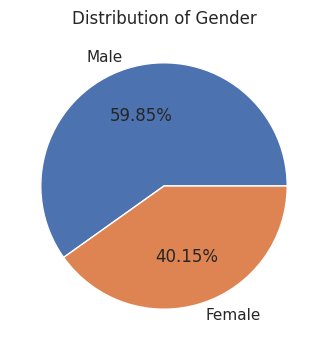

Location
USA       16000
Europe    12004
Asia       8095
Other      3935
Name: count, dtype: int64


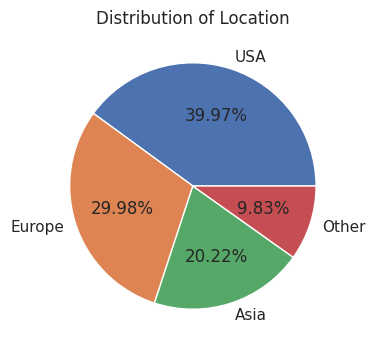

GameGenre
Sports        8048
Action        8039
Strategy      8012
Simulation    7983
RPG           7952
Name: count, dtype: int64


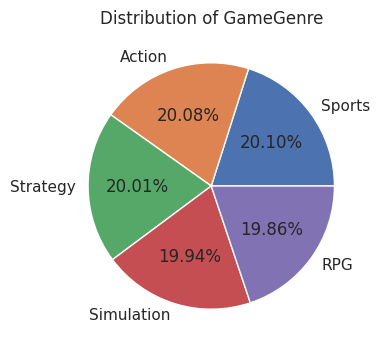

GameDifficulty
Easy      20015
Medium    12011
Hard       8008
Name: count, dtype: int64


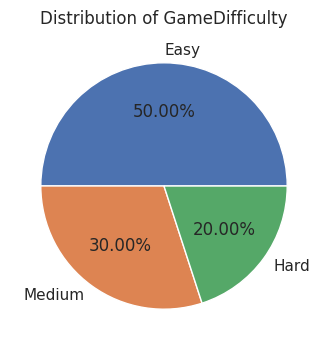

InGamePurchases
0    31993
1     8041
Name: count, dtype: int64


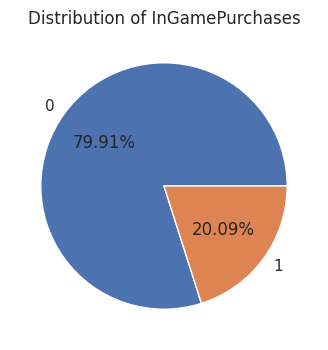

In [ ]:
cat_values_graph_pie(df,cat_values=cat_cols)

- **In the gender distribution graph**, we see that male actors outnumber female actors. The rate of male actors is 59.85% and the rate of female actors is 40.25%. When we look at both ratios, we see that the proportion of male actors is higher than the proportion of female actors however, we should also take into account the minority of female actors.

- In the graph showing the **location distribution**, we see that the largest player base is in the USA with 40%. In contrast, 60% of players are located in Europe, Asia and other continents. In this case, we can conclude that the number of people playing in the USA is quite high.

- **The distribution of GameGenre** is fairly balanced among all five genres, with each genre having a proportion close to 20%. This balance suggests that players in the dataset have diverse preferences across different types of games, with no single genre dominating the others significantly.

- The game's **difficulty graph** shows that 50% of players prefer the easy mode, which suggests that most players may want a more relaxed and less challenging experience. Those who choose the medium difficulty at 30% are seeking a balanced level of challenge. The 20% of players who select the hardest difficulty may be more experienced or looking for a greater sense of achievement.

- **In the game difficulty graph**, the majority of players prefer easy mode at 50%, indicating that most players may be looking for a more relaxed and less challenging gaming experience. Those who prefer the medium difficulty at 30% seek a balanced challenge that is neither too easy nor too hard.  Those who prefer the smaller but still notable 20% difficulty mode may be more experienced or looking for a greater sense of achievement.

- **In the InGamePurchases graph,** we can see that there are more people who don't buy and fewer who do.
It shows that 79.9% are happy with free content, don't see the value of in-game purchases, or are probably unable or unwilling to spend money on the game.

### Distribution among categorical variables

Location  Asia  Europe  Other   USA
Gender                             
Female    3251    4762   1580  6482
Male      4844    7242   2355  9518


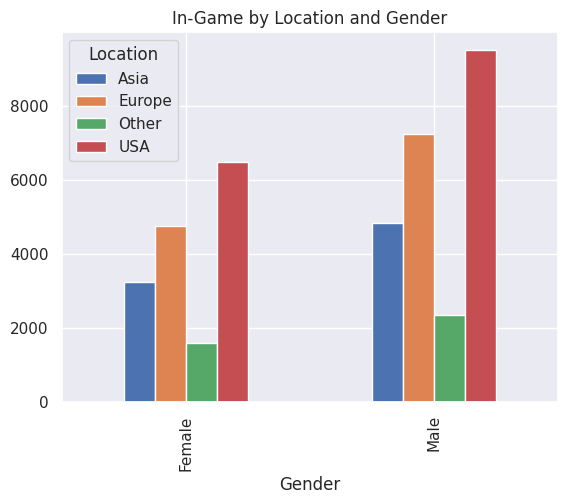

In [ ]:
location_genre= df.groupby(["Gender" , "Location"]).size().unstack()
print(location_genre)
location_genre.plot(kind='bar', stacked=False)
plt.title(f'In-Game by Location and Gender')
plt.show()

The highest participation for both genders is from the USA, while the lowest participation for both genders is from Other. Overall, for both genders, players from USA have the highest participation.

GameDifficulty   Easy  Hard  Medium
Gender                             
Female           8084  3234    4757
Male            11931  4774    7254


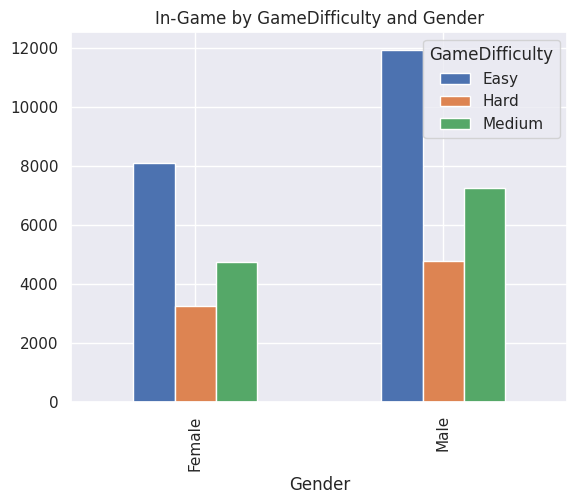

In [ ]:
gamedifficulty_genre= df.groupby(["Gender" , "GameDifficulty"]).size().unstack()
print(gamedifficulty_genre)
gamedifficulty_genre.plot(kind='bar', stacked=False)
plt.title(f'In-Game by GameDifficulty and Gender')
plt.show()

Participation is highest in Easy mode for both genders. Medium mode is more preferred than Hard mode.

Location    Asia  Europe  Other   USA
GameGenre                            
Action      1656    2428    792  3163
RPG         1620    2372    787  3173
Simulation  1623    2414    795  3151
Sports      1582    2431    775  3260
Strategy    1614    2359    786  3253


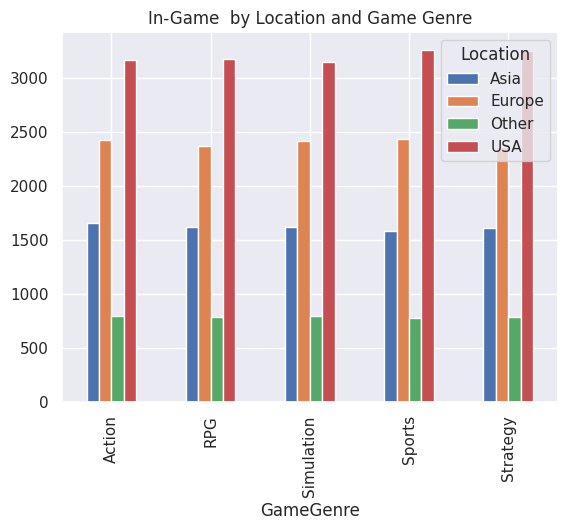

In [ ]:
genre_location=df.groupby(["GameGenre","Location"]).size().unstack()

print(genre_location)

genre_location.plot(kind='bar', stacked=False)
plt.title('In-Game  by Location and Game Genre')
plt.show()

Players from USA and Europe have the highest participation, while players from Asia and Other have lower participation. This reflects the popularity of game genres and player engagement by region.

### Distributions of Numerical Variables

<ipython-input-74-af2122fe7073>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Age'], shade=True, color='teal')


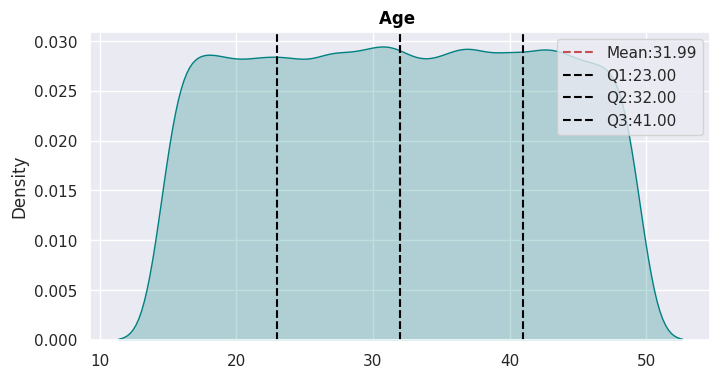

In [ ]:
fig,ax = plt.subplots(figsize = (8, 4))

mu = df["Age"].mean()
q1, q2, q3 = df["Age"].quantile([0.25, 0.5, 0.75])

sns.kdeplot(df['Age'], shade=True, color='teal')
ax.axvline(mu, linestyle = '--', color = 'r', label = f"Mean:{mu:.2f}")
ax.axvline(q1, linestyle = '--', color = 'black', label = f"Q1:{q1:.2f}")
ax.axvline(q2, linestyle = '--', color = 'black', label = f"Q2:{q2:.2f}")
ax.axvline(q3, linestyle = '--', color = 'black', label = f"Q3:{q3:.2f}")
ax.legend()
ax.set_xlabel("")
ax.set_title(f"Age ", fontweight = 'bold', color = 'black')
fig.show()

<ipython-input-75-307100abf03f>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['SessionsPerWeek'], shade=True, color='teal')


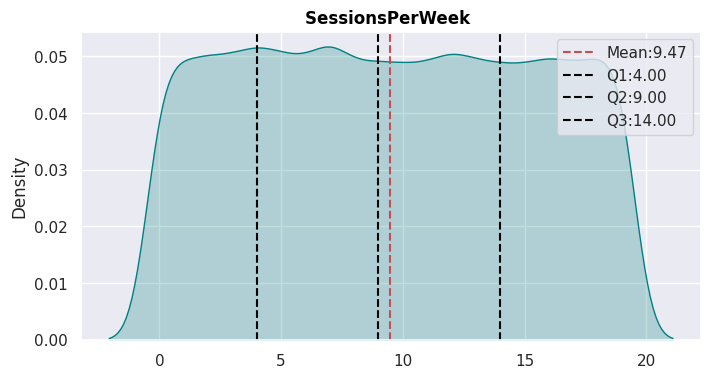

In [ ]:
fig,ax = plt.subplots(figsize = (8, 4))

mu = df["SessionsPerWeek"].mean()
q1, q2, q3 = df["SessionsPerWeek"].quantile([0.25, 0.5, 0.75])

sns.kdeplot(df['SessionsPerWeek'], shade=True, color='teal')
ax.axvline(mu, linestyle = '--', color = 'r', label = f"Mean:{mu:.2f}")
ax.axvline(q1, linestyle = '--', color = 'black', label = f"Q1:{q1:.2f}")
ax.axvline(q2, linestyle = '--', color = 'black', label = f"Q2:{q2:.2f}")
ax.axvline(q3, linestyle = '--', color = 'black', label = f"Q3:{q3:.2f}")
ax.legend()
ax.set_xlabel("")
ax.set_title(f"SessionsPerWeek ", fontweight = 'bold', color = 'black')
fig.show()

<ipython-input-76-8fa270ce2849>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['AvgSessionDurationMinutes'], shade=True, color='teal')


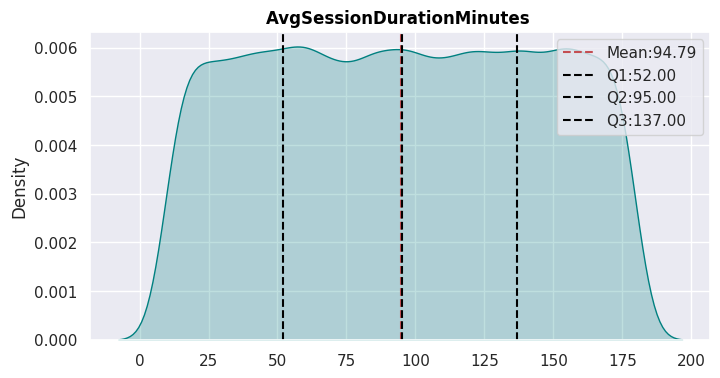

In [ ]:
fig,ax = plt.subplots(figsize = (8, 4))

mu = df["AvgSessionDurationMinutes"].mean()
q1, q2, q3 = df["AvgSessionDurationMinutes"].quantile([0.25, 0.5, 0.75])

sns.kdeplot(df['AvgSessionDurationMinutes'], shade=True, color='teal')
ax.axvline(mu, linestyle = '--', color = 'r', label = f"Mean:{mu:.2f}")
ax.axvline(q1, linestyle = '--', color = 'black', label = f"Q1:{q1:.2f}")
ax.axvline(q2, linestyle = '--', color = 'black', label = f"Q2:{q2:.2f}")
ax.axvline(q3, linestyle = '--', color = 'black', label = f"Q3:{q3:.2f}")
ax.legend()
ax.set_xlabel("")
ax.set_title(f"AvgSessionDurationMinutes ", fontweight = 'bold', color = 'black')
fig.show()

<ipython-input-77-5c3d8ecdaef1>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['AchievementsUnlocked'], shade=True, color='teal')


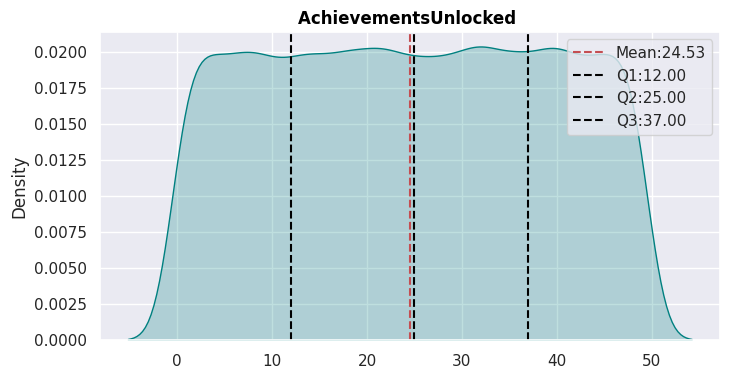

In [ ]:
fig,ax = plt.subplots(figsize = (8, 4))

mu = df["AchievementsUnlocked"].mean()
q1, q2, q3 = df["AchievementsUnlocked"].quantile([0.25, 0.5, 0.75])

sns.kdeplot(df['AchievementsUnlocked'], shade=True, color='teal')
ax.axvline(mu, linestyle = '--', color = 'r', label = f"Mean:{mu:.2f}")
ax.axvline(q1, linestyle = '--', color = 'black', label = f"Q1:{q1:.2f}")
ax.axvline(q2, linestyle = '--', color = 'black', label = f"Q2:{q2:.2f}")
ax.axvline(q3, linestyle = '--', color = 'black', label = f"Q3:{q3:.2f}")
ax.legend()
ax.set_xlabel("")
ax.set_title(f"AchievementsUnlocked ", fontweight = 'bold', color = 'black')
fig.show()

<ipython-input-78-78b500ed2e9d>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['PlayerLevel'], shade=True, color='teal')


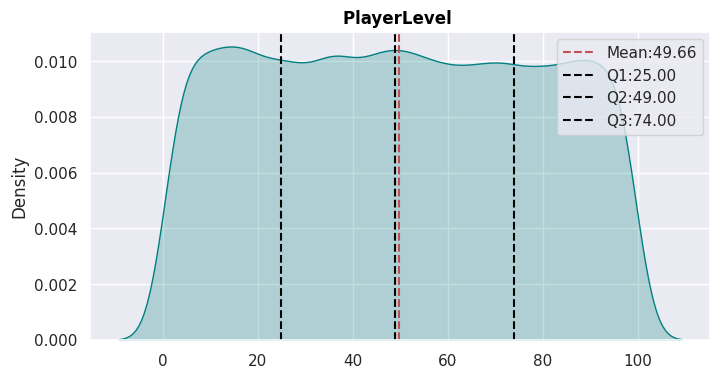

In [ ]:
fig,ax = plt.subplots(figsize = (8, 4))

mu = df["PlayerLevel"].mean()
q1, q2, q3 = df["PlayerLevel"].quantile([0.25, 0.5, 0.75])

sns.kdeplot(df['PlayerLevel'], shade=True, color='teal')
ax.axvline(mu, linestyle = '--', color = 'r', label = f"Mean:{mu:.2f}")
ax.axvline(q1, linestyle = '--', color = 'black', label = f"Q1:{q1:.2f}")
ax.axvline(q2, linestyle = '--', color = 'black', label = f"Q2:{q2:.2f}")
ax.axvline(q3, linestyle = '--', color = 'black', label = f"Q3:{q3:.2f}")
ax.legend()
ax.set_xlabel("")
ax.set_title(f"PlayerLevel ", fontweight = 'bold', color = 'black')
fig.show()

### Distributions according to Target variable

EngagementLevel
Medium    19374
High      10336
Low       10324
Name: count, dtype: int64


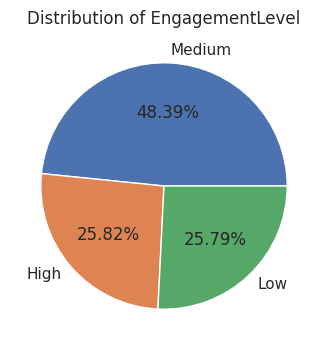

In [ ]:
engagement_lvl=df["EngagementLevel"].value_counts()

print(engagement_lvl)
plt.figure(figsize=(4, 4))
plt.pie(engagement_lvl, labels=engagement_lvl.index, autopct='%1.2f%%',  wedgeprops=dict(width=1))
plt.title(f'Distribution of {col}')
plt.show()

In [ ]:
def target_plot(dataframe,value):
    """
    Graphing function.

    This function creates and displays a bar chart about EngagementLevel
    by grouping over the specified values in a given pandas DataFrame.

    Args:
        dataframe (pd.DataFrame): Data source for the graph
        value (str): Column name for grouping
    """
    print(f"############## {value} ##############n")
    target_accor=dataframe.groupby(['EngagementLevel', value]).size().unstack()
    print(target_accor)
    target_accor.plot(kind='bar', stacked=False)
    plt.title(f'In-Game  by Engagement Level and {value}')
    plt.show()

############## GameGenre ##############n
GameGenre        Action   RPG  Simulation  Sports  Strategy
EngagementLevel                                            
High               2064  1988        2104    2083      2097
Low                2059  2097        2088    2074      2006
Medium             3916  3867        3791    3891      3909


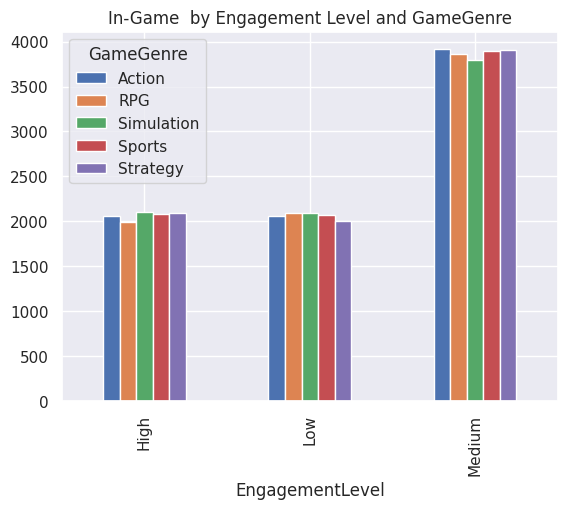

############## Gender ##############n
Gender           Female   Male
EngagementLevel               
High               4196   6140
Low                4121   6203
Medium             7758  11616


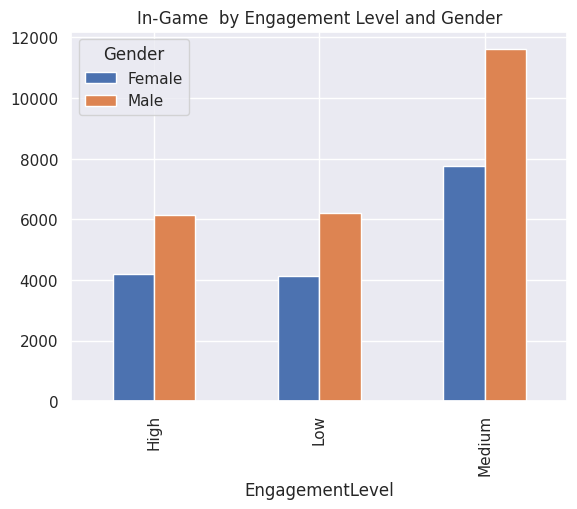

############## GameDifficulty ##############n
GameDifficulty   Easy  Hard  Medium
EngagementLevel                    
High             5132  2112    3092
Low              5206  2076    3042
Medium           9677  3820    5877


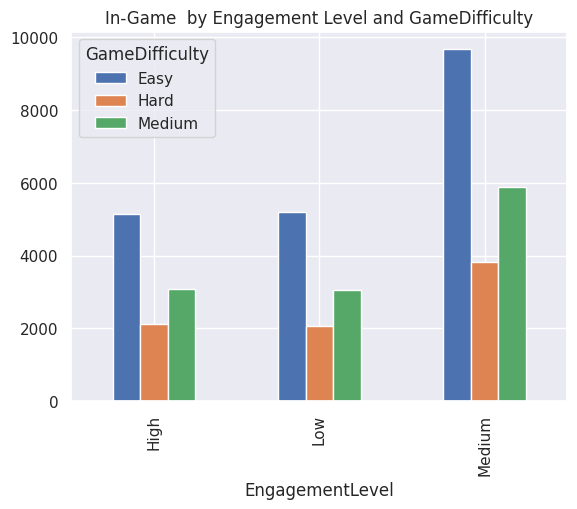

In [ ]:
target_order=["GameGenre","Gender","GameDifficulty"]

for tar_or in target_order:
    target_plot(df,tar_or)

*Engagement Level and Game Genre*

- **High Engagement:** Players with high engagement also make a significant number of purchases, with Simulation and Strategy being the top genres.
- **Low Engagement:** Players with low engagement make fewer purchases overall, but the distribution is quite balanced among the genres, with RPG and Strategy slightly leading.
- **Medium Engagement:** Players with medium engagement make the most in-game purchases across all genres, with Strategy and RPG being the most purchased.

*Engagement Level and Gender*

It shows that there are differences between genders at certain levels of participation. The number of male players is significantly higher, especially at the middle participation level.

*Engagement Level and Game Difficulty*

It reveals that players' in-game engagement levels differ according to game difficulty levels. In general, players' engagement is higher at the easy difficulty level.

### Heatmap

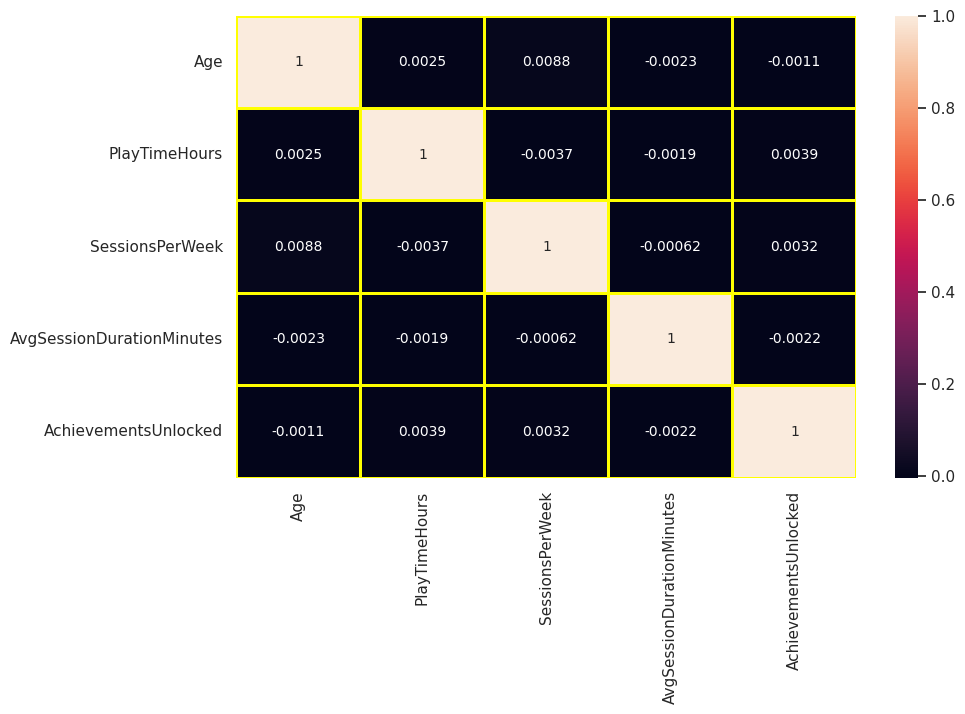

In [ ]:
correlation_matrix = df[num_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size":10},linewidths=2, linecolor='yellow')
plt.show()

# Feature Engineering

### New Variables

In [ ]:
df['Age_new'] = pd.cut(x=df['Age'], bins=[min(df["Age"])-1,19,27,38,max(df["Age"])], labels = ["Teenager","Young","Mature","Old_Mature"])

df['SessionsCategory'] = pd.cut(x=df['SessionsPerWeek'], bins=[-1,0,6,10,16,max(df["SessionsPerWeek"])], labels = ["Passive","Occasional","Regular","Frequent","Dedicated"])

df['PlayerLevelCategory'] = pd.cut(x=df['PlayerLevel'], bins=[-1,20,50,70,90,max(df["PlayerLevel"])], labels = ['Beginner', 'Intermediate', 'Advanced', 'Expert', 'Master'])

df['SessionDurationCategory'] = pd.cut(x=df['AvgSessionDurationMinutes'], bins=[9,50,130,max(df["AvgSessionDurationMinutes"])], labels = ['Duration_Short', 'Duration_Medium', 'Duration_Long'])

In [ ]:
age_list = df['Age_new'].unique().tolist()
session_list = df['SessionsCategory'].unique().tolist()
genre_list = df['GameDifficulty'].unique().tolist()
player_list = df['PlayerLevelCategory'].unique().tolist()
gender_list = df["Gender"].unique().tolist()

for age_n in range(len(df["Age_new"].value_counts())):
    for session_n in range(len(df["SessionsCategory"].value_counts())):

        df.loc[(df["Age_new"] == age_list[age_n]) & (df["SessionsCategory"] == session_list[session_n]),"Age_SessionsCategory"]=str(age_list[age_n])+"_" +str(session_list[session_n])

for age_n in range(len(df["Age_new"].value_counts())):
    for genre_n in range(len(df["GameDifficulty"].value_counts())):

        df.loc[(df["Age_new"] == age_list[age_n]) & (df["GameDifficulty"] == genre_list[genre_n]),"Age_GameDifficulty"]=str(age_list[age_n])+"_" +str(genre_list[genre_n])

for age_n in range(len(df["Age_new"].value_counts())):
    for player_n in range(len(df["PlayerLevelCategory"].value_counts())):
        df.loc[(df["Age_new"] == age_list[age_n]) & (df["PlayerLevelCategory"] == player_list[player_n]),"Age_PlayerLevelCategory"]=str(age_list[age_n])+"_" +str(player_list[player_n])


for gender_n in range(len(df["Gender"].value_counts())):
    for player_n in range(len(df["PlayerLevelCategory"].value_counts())):

        df.loc[(df["Gender"] == gender_list[gender_n]) & (df["PlayerLevelCategory"] == player_list[player_n]),"Gender_PlayerLevelCategory"]=str(gender_list[gender_n])+"_" +str(player_list[player_n])


for gender_n in range(len(df["Gender"].value_counts())):
    for session_n in range(len(df["SessionsCategory"].value_counts())):

        df.loc[(df["Gender"] == gender_list[gender_n]) & (df["SessionsCategory"] == session_list[session_n]),"Gender_SessionsCategory"]=str(gender_list[gender_n])+"_" +str(session_list[session_n])

for gender_n in range(len(df["Gender"].value_counts())):
    for age_n in range(len(df["Age_new"].value_counts())):

        df.loc[(df["Gender"] == gender_list[gender_n]) & (df["Age_new"] == age_list[age_n]),"Gender_Age_new"]=str(gender_list[gender_n])+"_" +str(age_list[age_n])


In [ ]:
cat_cols, num_cols, cat_but_car=grab_col_names(df)

Observations: 40034
Variables: 23
cat_cols: 15
num_cols: 5
cat_but_car: 0
num_but_cat: 1


# Encoding Operations

In [ ]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in cat_cols if df[col].nunique() == 2]
#binary_cols.append("EngagementLevel")
for col in binary_cols:
    df = label_encoder(df,col)

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

cat_cols = [col for col in cat_cols if col not in binary_cols]

df = one_hot_encoder(df, cat_cols, drop_first=True)

####  Standardize for numerical variables.

In [ ]:
df= df.drop("PlayerID",axis=1)
df[num_cols] = RobustScaler().fit_transform(df[num_cols])
df[num_cols].head()

,Age,PlayTimeHours,SessionsPerWeek,AvgSessionDurationMinutes,AchievementsUnlocked
0,0.611,0.358,-0.300,0.153,0.000
1,-0.167,-0.545,-0.400,0.576,-0.600
2,-0.556,-0.318,0.700,0.553,0.640
3,0.167,-0.567,0.000,-0.118,0.880
4,0.056,0.296,-0.700,0.424,0.480


In [ ]:
enga_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['EngagementLevel'] = df['EngagementLevel'].map(enga_map)

# Models

In [ ]:
df.head()

,Age,Gender,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,Location_Europe,Location_Other,Location_USA,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Hard,GameDifficulty_Medium,Age_new_Young,Age_new_Mature,Age_new_Old_Mature,SessionsCategory_Occasional,SessionsCategory_Regular,SessionsCategory_Frequent,SessionsCategory_Dedicated,PlayerLevelCategory_Intermediate,PlayerLevelCategory_Advanced,PlayerLevelCategory_Expert,PlayerLevelCategory_Master,SessionDurationCategory_Duration_Medium,SessionDurationCategory_Duration_Long,Age_SessionsCategory_Mature_Frequent,Age_SessionsCategory_Mature_Occasional,Age_SessionsCategory_Mature_Passive,Age_SessionsCategory_Mature_Regular,Age_SessionsCategory_Old_Mature_Dedicated,Age_SessionsCategory_Old_Mature_Frequent,Age_SessionsCategory_Old_Mature_Occasional,Age_SessionsCategory_Old_Mature_Passive,Age_SessionsCategory_Old_Mature_Regular,Age_SessionsCategory_Teenager_Dedicated,Age_SessionsCategory_Teenager_Frequent,Age_SessionsCategory_Teenager_Occasional,Age_SessionsCategory_Teenager_Passive,Age_SessionsCategory_Teenager_Regular,Age_SessionsCategory_Young_Dedicated,Age_SessionsCategory_Young_Frequent,Age_SessionsCategory_Young_Occasional,Age_SessionsCategory_Young_Passive,Age_SessionsCategory_Young_Regular,Age_GameDifficulty_Mature_Hard,Age_GameDifficulty_Mature_Medium,Age_GameDifficulty_Old_Mature_Easy,Age_GameDifficulty_Old_Mature_Hard,Age_GameDifficulty_Old_Mature_Medium,Age_GameDifficulty_Teenager_Easy,Age_GameDifficulty_Teenager_Hard,Age_GameDifficulty_Teenager_Medium,Age_GameDifficulty_Young_Easy,Age_GameDifficulty_Young_Hard,Age_GameDifficulty_Young_Medium,Age_PlayerLevelCategory_Mature_Beginner,Age_PlayerLevelCategory_Mature_Expert,Age_PlayerLevelCategory_Mature_Intermediate,Age_PlayerLevelCategory_Mature_Master,Age_PlayerLevelCategory_Old_Mature_Advanced,Age_PlayerLevelCategory_Old_Mature_Beginner,Age_PlayerLevelCategory_Old_Mature_Expert,Age_PlayerLevelCategory_Old_Mature_Intermediate,Age_PlayerLevelCategory_Old_Mature_Master,Age_PlayerLevelCategory_Teenager_Advanced,Age_PlayerLevelCategory_Teenager_Beginner,Age_PlayerLevelCategory_Teenager_Expert,Age_PlayerLevelCategory_Teenager_Intermediate,Age_PlayerLevelCategory_Teenager_Master,Age_PlayerLevelCategory_Young_Advanced,Age_PlayerLevelCategory_Young_Beginner,Age_PlayerLevelCategory_Young_Expert,Age_PlayerLevelCategory_Young_Intermediate,Age_PlayerLevelCategory_Young_Master,Gender_PlayerLevelCategory_Female_Beginner,Gender_PlayerLevelCategory_Female_Expert,Gender_PlayerLevelCategory_Female_Intermediate,Gender_PlayerLevelCategory_Female_Master,Gender_PlayerLevelCategory_Male_Advanced,Gender_PlayerLevelCategory_Male_Beginner,Gender_PlayerLevelCategory_Male_Expert,Gender_PlayerLevelCategory_Male_Intermediate,Gender_PlayerLevelCategory_Male_Master,Gender_SessionsCategory_Female_Frequent,Gender_SessionsCategory_Female_Occasional,Gender_SessionsCategory_Female_Passive,Gender_SessionsCategory_Female_Regular,Gender_SessionsCategory_Male_Dedicated,Gender_SessionsCategory_Male_Frequent,Gender_SessionsCategory_Male_Occasional,Gender_SessionsCategory_Male_Passive,Gender_SessionsCategory_Male_Regular,Gender_Age_new_Female_Old_Mature,Gender_Age_new_Female_Teenager,Gender_Age_new_Female_Young,Gender_Age_new_Male_Mature,Gender_Age_new_Male_Old_Mature,Gender_Age_new_Male_Teenager,Gender_Age_new_Male_Young
0,0.611,1,0.358,0,-0.300,0.153,79,0.000,1,False,True,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,Tr

In [ ]:
y = df["EngagementLevel"]
X = df.drop(["EngagementLevel"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=1234)

classifiers = [('KNN Classifier', KNeighborsClassifier()),
                   ("CART Classifier", DecisionTreeClassifier()),
                   ('Adaboost Classifier', AdaBoostClassifier()),
                   ("RF Classifier", RandomForestClassifier()),
                   ('XGBoost Classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss',n_jobs = -1)),
                   ('LightGBM Classifier', LGBMClassifier(verbosity = -1))
                   ]

In [ ]:
def hold_out_vali(model, model_name, x_tr, y_tr, x_ts, y_ts, plot=False):
    """
    Performs hold-out validation for the given model and prints the results.

    Args:
        model (sklearn.neighbors._classification.model): Classifier model to be trained and tested.
        model_name (str):  Name of the model.
        x_tr (pandas.core.frame.DataFrame): Characteristics of the training data set.
        y_tr (pandas.core.series.Series): The target variable of the training data set.
        x_ts (pandas.core.frame.DataFrame): Characteristics of the test data set.
        y_ts (pandas.core.series.Series): Characteristics of the test data set.
        plot (bool, optional): Plot confusion matrix to visualize validation results? The default value is False.
    """

    print(f"*"*30+" " + model_name+" " + "*"*30)

    model.fit(x_tr, y_tr)
    y_pred =model.predict(x_ts)
    accuracy= accuracy_score(y_pred, y_ts)
    print(f"{model_name} accuracy :{accuracy.__round__(3)}")
    print(classification_report(y_ts,y_pred))

    if plot:
        conf_matrix = confusion_matrix(y_ts,y_pred)
        ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_).plot()
        plt.title('Confution Matrix')
        plt.show()

    return accuracy

In [ ]:
accuracy_models = {}
for index ,(name, classifier) in enumerate (classifiers):
         accuracy_models[name] =(hold_out_vali(classifier,name,X_train,y_train,X_test,y_test))

****************************** KNN Classifier ******************************
KNN Classifier accuracy :0.663
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      3115
           1       0.65      0.75      0.69      5819
           2       0.73      0.61      0.66      3077

    accuracy                           0.66     12011
   macro avg       0.67      0.64      0.65     12011
weighted avg       0.67      0.66      0.66     12011

****************************** CART Classifier ******************************
CART Classifier accuracy :0.831
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3115
           1       0.86      0.86      0.86      5819
           2       0.81      0.81      0.81      3077

    accuracy                           0.83     12011
   macro avg       0.82      0.82      0.82     12011
weighted avg       0.83      0.83      0.83     12011

********************

#### Hyperparameter Optimization

In [ ]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

adaboost_params = {'n_estimators': [50, 100, 150],
                    'learning_rate': [0.01, 0.1]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.5, 1]}

classifiers_hypers = [('KNN Classifier', KNeighborsClassifier(), knn_params),
                    ("CART Classifier", DecisionTreeClassifier(), cart_params),
                    ("Adaboost Classifier",AdaBoostClassifier(), adaboost_params),
                    ("RF Classifier", RandomForestClassifier(), rf_params),
                    ('XGBoost Classifier' , XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
                    ('LightGBM Classifier', LGBMClassifier(), lightgbm_params)]

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

In [ ]:
def hyperparameter_optimization(hyperparam_model, hyperparam_name,param,X_tr, y_tr,X_ts, y_ts, cv=3):
        print("Hyperparameter Optimization....")

        gs_best = GridSearchCV(hyperparam_model, param, cv=cv, n_jobs=-1, verbose=True).fit(X_tr, y_tr)
        final_model = classifier.set_params(**gs_best.best_params_)
        gs_best = gs_best.best_estimator_
        y_pred = gs_best.predict(X_ts)
        accuracy = accuracy_score(y_ts, y_pred)

        print(f"{hyperparam_name} test seti üzerinde accuracy skoru:", accuracy)
        print(classification_report(y_ts,y_pred))
        print(final_model)

        return accuracy

In [ ]:
hyperparameter_accuracy= {}

for index ,(classifiers_hyper_name, classifiers_hyper, params) in enumerate (classifiers_hypers):
         hyperparameter_accuracy[classifiers_hyper_name]=(hyperparameter_optimization(classifiers_hyper, classifiers_hyper_name,params, X_train, y_train, X_test, y_test))



Hyperparameter Optimization....
Fitting 3 folds for each of 48 candidates, totalling 144 fits
KNN Classifier test seti üzerinde accuracy skoru: 0.6775455832153859
              precision    recall  f1-score   support

           0       0.67      0.53      0.59      3115
           1       0.65      0.79      0.71      5819
           2       0.76      0.60      0.67      3077

    accuracy                           0.68     12011
   macro avg       0.69      0.64      0.66     12011
weighted avg       0.68      0.68      0.67     12011

LGBMClassifier(n_neighbors=11, verbosity=-1)
Hyperparameter Optimization....
Fitting 3 folds for each of 532 candidates, totalling 1596 fits
CART Classifier test seti üzerinde accuracy skoru: 0.8981766713845641
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3115
           1       0.89      0.93      0.91      5819
           2       0.91      0.88      0.90      3077

    accuracy               

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RF Classifier test seti üzerinde accuracy skoru: 0.8908500541170593
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3115
           1       0.88      0.94      0.91      5819
           2       0.92      0.86      0.89      3077

    accuracy                           0.89     12011
   macro avg       0.90      0.88      0.89     12011
weighted avg       0.89      0.89      0.89     12011

LGBMClassifier(max_depth=None, max_features='auto', min_samples_split=15,
               n_estimators=200, n_neighbors=11, verbosity=-1)
Hyperparameter Optimization....
Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost Classifier test seti üzerinde accuracy skoru: 0.9142452751644327
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3115
           1       0.91      0.95      0.93      5819
           2       0.92      0.88      0.90      3077

    accuracy                   

In [ ]:
def accuracy_comparison():

    best_accuracy=0
    best_hyperparameter=0
    best_accuracy_model = ""
    best_hyperparameter_model = ""
    hyperparameter_ac = 0

    for (model, value) in (accuracy_models.items()):
            accuracy_ac = value
            hyperparameter_ac = hyperparameter_accuracy[model]

            print("#" * 50)
            print(f"\n\n{model} accuracy without Hyperparameter: {accuracy_ac}")
            print(f"{model} accuracy with Hyperparameter: {hyperparameter_ac}\n\n")

            # En iyi accuracy'yi bulma
            if accuracy_ac > best_accuracy:
                best_accuracy = accuracy_ac
                best_accuracy_model = model

            # En iyi hyperparameter accuracy'yi bulma
            if hyperparameter_ac > best_hyperparameter:
                best_hyperparameter = hyperparameter_ac
                best_hyperparameter_model = model
    print("############# Best Models ############# ")
    print(f"Best {best_accuracy_model} accuracy without Hyperparameter: {accuracy_ac} ")
    print(f"Best {best_hyperparameter_model} accuracy with Hyperparameter: {hyperparameter_ac} ")


In [ ]:
accuracy_comparison()

##################################################


KNN Classifier accuracy without Hyperparameter: 0.6633086337523937
KNN Classifier accuracy with Hyperparameter: 0.6775455832153859


##################################################


CART Classifier accuracy without Hyperparameter: 0.8308217467321621
CART Classifier accuracy with Hyperparameter: 0.8981766713845641


##################################################


Adaboost Classifier accuracy without Hyperparameter: 0.8003496794604945
Adaboost Classifier accuracy with Hyperparameter: 0.7999333943884772


##################################################


RF Classifier accuracy without Hyperparameter: 0.8890183998001832
RF Classifier accuracy with Hyperparameter: 0.8908500541170593


##################################################


XGBoost Classifier accuracy without Hyperparameter: 0.9137457330780118
XGBoost Classifier accuracy with Hyperparameter: 0.9142452751644327


##################################################



Even though hyperparameter optimization hasn't improved your model's performance by much, your current model already produces pretty good results.

In [ ]:
def final_report(datafarame,X_tr,y_tr,X_ts,y_ts,plot=False,plot_importance=False):

    lgbm_model= LGBMClassifier(verbosity = -1)
    lgbm_model.fit(X_train, y_train)
    y_pred =lgbm_model.predict(X_test)
    lgbm_accuracy= accuracy_score(y_true=y_test, y_pred =y_pred)

    print(f"LGBMClassifier  accuracy :{lgbm_accuracy.__round__(4)}")
    print(classification_report(y_test,y_pred))


    if plot:
        conf_matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=True, linecolor='white', linewidths=0)
        plt.title('Confution Matrix')
        plt.show()

    if plot_importance:
        feature_imp = pd.DataFrame({'Value': lgbm_model.feature_importances_, 'Feature': X_train.columns})
        plt.figure(figsize=(8, 8))
        sns.set(font_scale=1)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                        ascending=False)[0:20])
        plt.title('LGBM Classifier Features')
        plt.tight_layout()
        plt.show()


LGBMClassifier  accuracy :0.9156
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3115
           1       0.91      0.95      0.93      5819
           2       0.92      0.89      0.90      3077

    accuracy                           0.92     12011
   macro avg       0.92      0.91      0.91     12011
weighted avg       0.92      0.92      0.92     12011



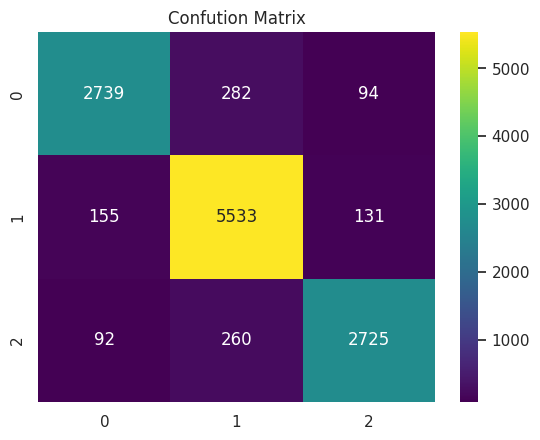

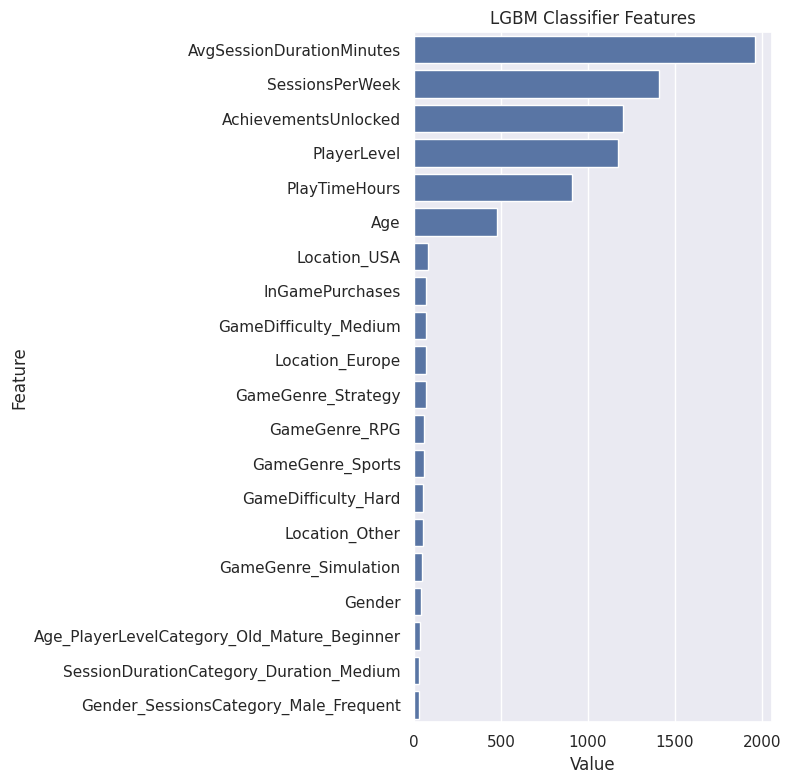

In [ ]:
final_report(df,X_train,y_train, X_test, y_test, plot=True,plot_importance=True)

# Result Confution Matrix

**Correct Classifications:**

- The model made 1812 correct predictions for class 0.
- He made 3687 correct predictions for Class 1.
- He made 1827 correct predictions for Class 2.

**Misclassifications:**

- The model made 192 56 = 248 incorrect predictions for class 0.
- For Class 1, he made 108 90 = 198 wrong guesses.
- For Class 2, he made 58 177=235 wrong guesses.


**Performance Indicators:**

- The model showed the best performance on class 1 because it has the highest number of correct classifications (3687).
- It also performed quite well for class 0 and class 2, but there were some misclassifications.


#  Result Feature Graph

The LGBM Classifier Features graph helps us understand which factors need more attention by showing which features are most influential in the model's decision-making process.

For example, the average session duration of players and the number of sessions per week are important features to focus on when analyzing player behavior and improving model performance.